 Hackathon Submissions 2025


In [16]:
import numpy as np
import matplotlib.pyplot as plt

from ase.build import graphene
from ase import Atoms

import abtem
from abtem import Potential

from scipy.interpolate import griddata
from scipy.ndimage import grey_dilation, gaussian_filter

from skimage.registration import phase_cross_correlation
from skimage.feature import canny

In [37]:
# Build graphene (ground truth for TEM and AFM)
atoms = graphene(
    size=(10, 10, 1),
    a=2.46,
    vacuum=15.0
)

# Add out-of-plane ripples (realistic for suspended graphene)
coords = atoms.get_positions()
coords[:, 2] += 0.35 * np.sin(coords[:, 0] / 6) * np.cos(coords[:, 1] / 6)
atoms.set_positions(coords)

In [38]:
# TEM simulation, parameters
energy = 80e3  # 80 keV (graphene-safe)
defocus = -10e-9  # underfocus (meters)

potential = Potential(
    atoms,
    sampling=0.05  # Å / pixel
)

probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=25e-3,
    defocus=defocus
)

# Multislice TEM image
tem_image = probe.multislice(potential).intensity().compute()

# Normalize
tem_image = tem_image / tem_image.max()

[########################################] | 100% Completed | 10.29 ss


In [43]:
#AFM simulation (height map)

xyz = atoms.get_positions()
x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

grid_size = tem_image.shape[0]
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), grid_size),
    np.linspace(y.min(), y.max(), grid_size)
)

# Coordinate ranges
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Bin atoms into pixels
ix = ((x - xmin) / (xmax - xmin) * (grid_size - 1)).astype(int)
iy = ((y - ymin) / (ymax - ymin) * (grid_size - 1)).astype(int)

# Take maximum height per pixel (AFM upper envelope)
for i in range(len(z)):
    height_map[iy[i], ix[i]] = max(height_map[iy[i], ix[i]], z[i])

# Replace empty pixels
height_map[height_map == -np.inf] = np.nanmin(z)

In [44]:
# AFM tip parameters (convolution, essential for realism)
tip_radius_nm = 5
pixels_per_nm = 10
tip_pixels = int(tip_radius_nm * pixels_per_nm)

afm_image = grey_dilation(
    height_map,
    size=(tip_pixels, tip_pixels)
)

# Smooth & noise
afm_image = gaussian_filter(afm_image, sigma=1.0)
afm_image += np.random.normal(scale=0.02, size=afm_image.shape)

# Normalize
afm_image -= afm_image.min()
afm_image /= afm_image.max()

In [46]:
np.isnan(height_map).any()  # False

True

In [48]:
print("Height map NaNs:", np.isnan(height_map).sum())
print("AFM NaNs:", np.isnan(afm_image).sum())
print("Height range:", height_map.min(), height_map.max())

Height map NaNs: 75708
AFM NaNs: 242064
Height range: nan nan


In [50]:
import numpy as np
from scipy.ndimage import grey_dilation, gaussian_filter

# atomic coordinates
x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]

grid_size = 512  # pixels for AFM image

# Initialize empty height map
height_map = np.full((grid_size, grid_size), -np.inf)

# Coordinate ranges
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Map atoms to pixel indices
ix = ((x - xmin) / (xmax - xmin) * (grid_size - 1)).astype(int)
iy = ((y - ymin) / (ymax - ymin) * (grid_size - 1)).astype(int)

# Populate height map with max height per pixel
for i in range(len(z)):
    height_map[iy[i], ix[i]] = max(height_map[iy[i], ix[i]], z[i])

# Replace any remaining -inf (empty pixels) with min height
height_map[height_map == -np.inf] = z.min()

# AFM tip convolution
tip_radius_px = 5  # example
afm_image = grey_dilation(height_map, size=(tip_radius_px, tip_radius_px))

# Optional smoothing and noise
afm_image = gaussian_filter(afm_image, sigma=1.0)
afm_image += np.random.normal(scale=0.02, size=afm_image.shape)

# Normalize to 0-1
afm_image -= afm_image.min()
afm_image /= afm_image.max()

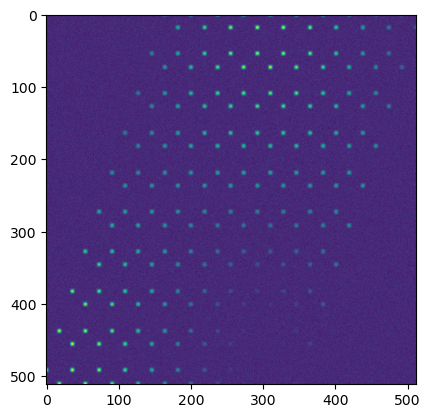

In [51]:
plt.imshow(afm_image)

In [55]:
# Multislice TEM image (abTEM)
tem_measurement = probe.multislice(potential).intensity()

# Extract raw NumPy array (CRITICAL)
tem_image = tem_measurement.array

# Normalize
tem_image = tem_image / tem_image.max()

In [56]:
type(tem_image)

dask.array.core.Array

In [57]:
type(afm_image)

numpy.ndarray

In [62]:
(afm_image).shape

(512, 512)

In [63]:
tem_image.shape

(492, 853)

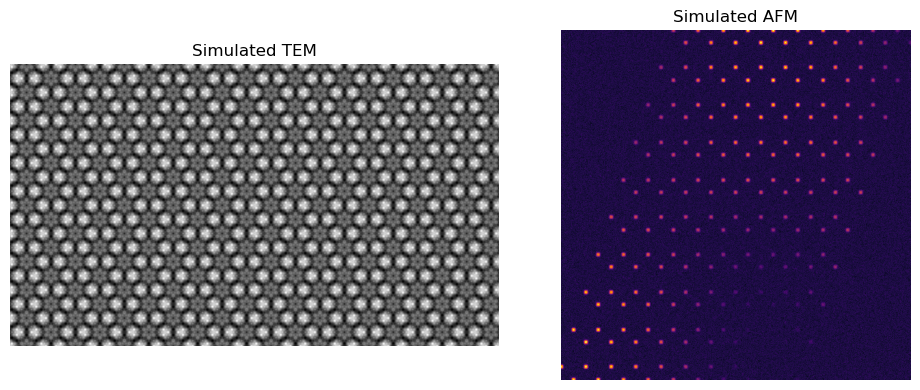

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), squeeze=False)

axes[0, 0].imshow(tem_image, cmap="gray")
axes[0, 0].set_title("Simulated TEM")
axes[0, 0].axis("off")

axes[0, 1].imshow(afm_image, cmap="inferno")
axes[0, 1].set_title("Simulated AFM")
axes[0, 1].axis("off")

plt.tight_layout()
plt.show()

RuntimeError: Base axes cannot be indexed.

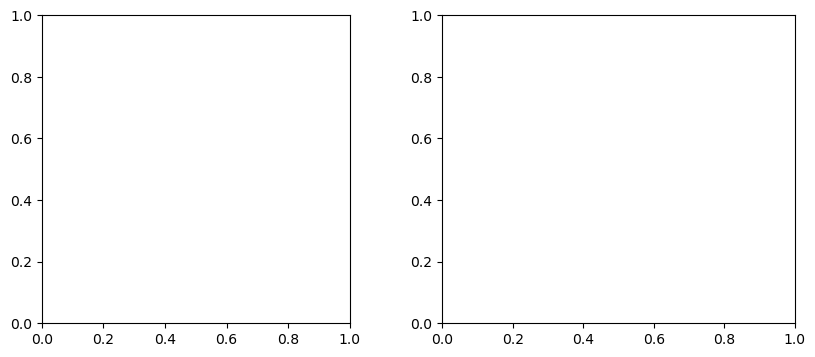

In [26]:
#side-by-side visulaisation

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(tem_image, cmap="gray")
axes[0].set_title("Simulated TEM (abTEM)")
axes[0].axis("off")

axes[1].imshow(afm_image, cmap="inferno")
axes[1].set_title("Simulated AFM")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [1]:
# graphene_tem_afm_correlative.py
import numpy as np
import matplotlib.pyplot as plt
from ase.build import graphene

import abtem
from abtem import Potential
from abtem import Probe

from scipy.ndimage import grey_dilation, gaussian_filter
from skimage.transform import resize
from skimage.feature import canny
from skimage.registration import phase_cross_correlation

In [2]:
# ================================
# 1. Build rippled graphene
# ================================
atoms = graphene(size=(10, 10, 1), a=2.46, vacuum=15.0)

coords = atoms.get_positions()
coords[:, 2] += 0.35 * np.sin(coords[:, 0] / 6) * np.cos(coords[:, 1] / 6)
atoms.set_positions(coords)

# Extract xyz for AFM
x, y, z = atoms.get_positions().T

In [3]:
# ================================
# 2. TEM simulation (abTEM)
# ================================
potential = Potential(atoms, sampling=0.05)  # Å/pixel
probe = Probe(energy=80e3, semiangle_cutoff=25e-3, defocus=-10e-9)

# Multislice
tem_measurement = probe.multislice(potential).intensity()

# Dask -> NumPy
tem_image = tem_measurement.array.compute()
tem_image /= tem_image.max()  # normalize

In [4]:
# ================================
# 3. AFM simulation (tip-convoluted)
# ================================
grid_size = 512
height_map = np.full((grid_size, grid_size), -np.inf)

# Map atomic coordinates to pixels
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
ix = ((x - xmin) / (xmax - xmin) * (grid_size - 1)).astype(int)
iy = ((y - ymin) / (ymax - ymin) * (grid_size - 1)).astype(int)

for i in range(len(z)):
    height_map[iy[i], ix[i]] = max(height_map[iy[i], ix[i]], z[i])

# Fill empty pixels with minimum height
height_map[height_map == -np.inf] = z.min()

# Tip convolution
tip_radius_px = 5
afm_image = grey_dilation(height_map, size=(tip_radius_px, tip_radius_px))
afm_image = gaussian_filter(afm_image, sigma=1.0)
afm_image += np.random.normal(scale=0.02, size=afm_image.shape)
afm_image -= afm_image.min()
afm_image /= afm_image.max()

In [5]:
# ================================
# 4. Resample AFM to TEM grid
# ================================
afm_resampled = resize(afm_image, tem_image.shape, mode='reflect', anti_aliasing=True)

In [6]:
# ================================
# 5. Correlation analysis
# ================================
# Pixel-wise correlation
corr_coeff = np.corrcoef(tem_image.flatten(), afm_resampled.flatten())[0, 1]
print(f"Pixel-wise TEM–AFM correlation: {corr_coeff:.3f}")

# Local correlation map
window = 32
corr_map = np.zeros_like(tem_image)
h, w = tem_image.shape

for i in range(0, h - window, window):
    for j in range(0, w - window, window):
        t = tem_image[i:i+window, j:j+window].flatten()
        a = afm_resampled[i:i+window, j:j+window].flatten()
        corr_map[i:i+window, j:j+window] = np.corrcoef(t, a)[0,1]

Pixel-wise TEM–AFM correlation: 0.015


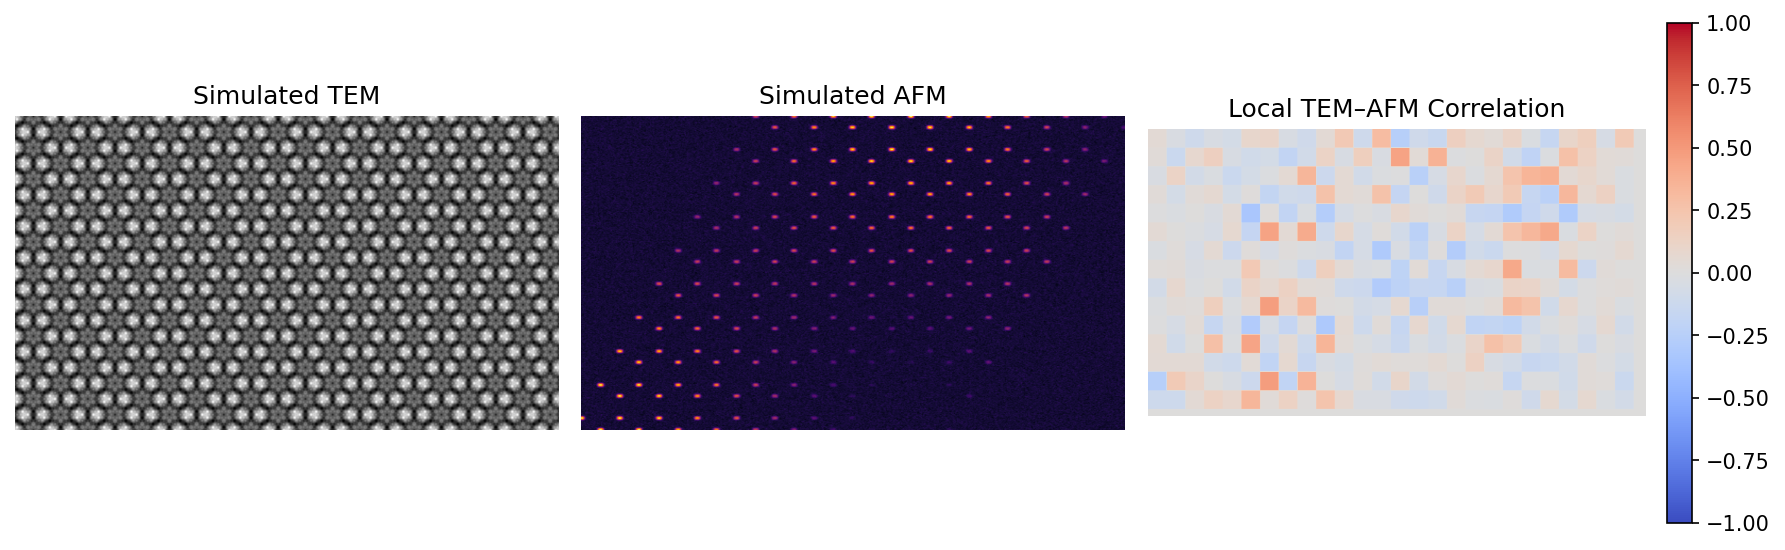

In [7]:
# ================================
# 6. Side-by-side visualization
# ================================
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

axes[0].imshow(tem_image, cmap='gray')
axes[0].set_title('Simulated TEM')
axes[0].axis('off')

axes[1].imshow(afm_resampled, cmap='inferno')
axes[1].set_title('Simulated AFM')
axes[1].axis('off')

im = axes[2].imshow(corr_map, cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title('Local TEM–AFM Correlation')
axes[2].axis('off')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [1]:
# graphene_tem_afm_correlative.py
import numpy as np
import matplotlib.pyplot as plt
from ase.build import graphene

import abtem
from abtem import Potential
from abtem import Probe

from scipy.ndimage import grey_dilation, gaussian_filter
from skimage.transform import resize
from skimage.feature import canny
from skimage.registration import phase_cross_correlation

In [2]:
# ================================
# 1. Build rippled graphene
# ================================
atoms = graphene(size=(10, 10, 1), a=2.46, vacuum=15.0)

coords = atoms.get_positions()
coords[:, 2] += 0.35 * np.sin(coords[:, 0] / 6) * np.cos(coords[:, 1] / 6)
atoms.set_positions(coords)

# Extract xyz for AFM
x, y, z = atoms.get_positions().T

# ================================
# 2. TEM simulation (abTEM)
# ================================
potential = Potential(atoms, sampling=0.05)  # Å/pixel
probe = Probe(energy=80e3, semiangle_cutoff=25e-3, defocus=-10e-9)

# Multislice
tem_measurement = probe.multislice(potential).intensity()

# Dask -> NumPy
tem_image = tem_measurement.array.compute()
tem_image /= tem_image.max()  # normalize

# ================================
# 3. AFM simulation (tip-convoluted)
# ================================
grid_size = 512
height_map = np.full((grid_size, grid_size), -np.inf)

# Map atomic coordinates to pixels
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
ix = ((x - xmin) / (xmax - xmin) * (grid_size - 1)).astype(int)
iy = ((y - ymin) / (ymax - ymin) * (grid_size - 1)).astype(int)

for i in range(len(z)):
    height_map[iy[i], ix[i]] = max(height_map[iy[i], ix[i]], z[i])

# Fill empty pixels with minimum height
height_map[height_map == -np.inf] = z.min()

# Tip convolution
tip_radius_px = 5
afm_image = grey_dilation(height_map, size=(tip_radius_px, tip_radius_px))
afm_image = gaussian_filter(afm_image, sigma=1.0)
afm_image += np.random.normal(scale=0.02, size=afm_image.shape)
afm_image -= afm_image.min()
afm_image /= afm_image.max()

Pixel-wise TEM–AFM correlation: 0.017


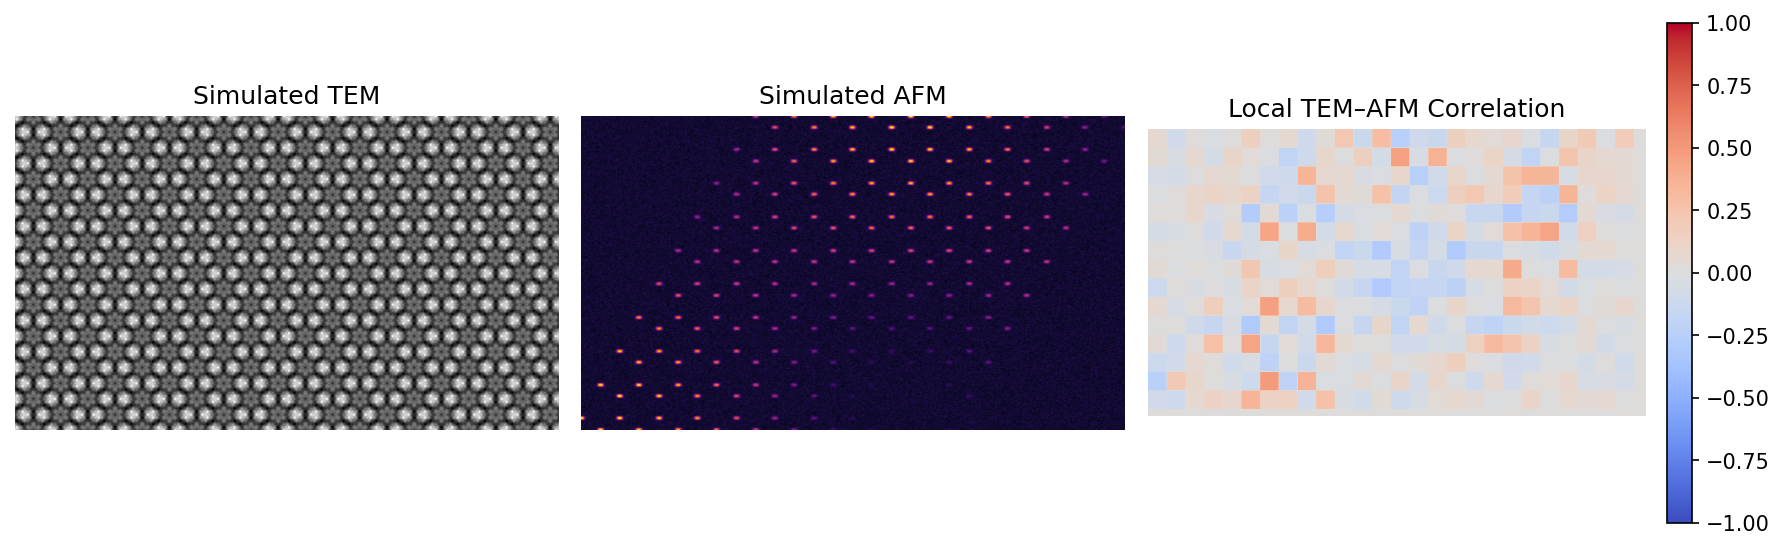

In [3]:
# ================================
# 4. Resample AFM to TEM grid
# ================================
afm_resampled = resize(afm_image, tem_image.shape, mode='reflect', anti_aliasing=True)

# ================================
# 5. Correlation analysis
# ================================
# Pixel-wise correlation
corr_coeff = np.corrcoef(tem_image.flatten(), afm_resampled.flatten())[0, 1]
print(f"Pixel-wise TEM–AFM correlation: {corr_coeff:.3f}")

# Local correlation map
window = 32
corr_map = np.zeros_like(tem_image)
h, w = tem_image.shape

for i in range(0, h - window, window):
    for j in range(0, w - window, window):
        t = tem_image[i:i+window, j:j+window].flatten()
        a = afm_resampled[i:i+window, j:j+window].flatten()
        corr_map[i:i+window, j:j+window] = np.corrcoef(t, a)[0,1]

# ================================
# 6. Side-by-side visualization
# ================================
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

axes[0].imshow(tem_image, cmap='gray')
axes[0].set_title('Simulated TEM')
axes[0].axis('off')

axes[1].imshow(afm_resampled, cmap='inferno')
axes[1].set_title('Simulated AFM')
axes[1].axis('off')

im = axes[2].imshow(corr_map, cmap='coolwarm', vmin=-1, vmax=1)
axes[2].set_title('Local TEM–AFM Correlation')
axes[2].axis('off')
fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [10]:
tem_pixel_size_nm = 0.005

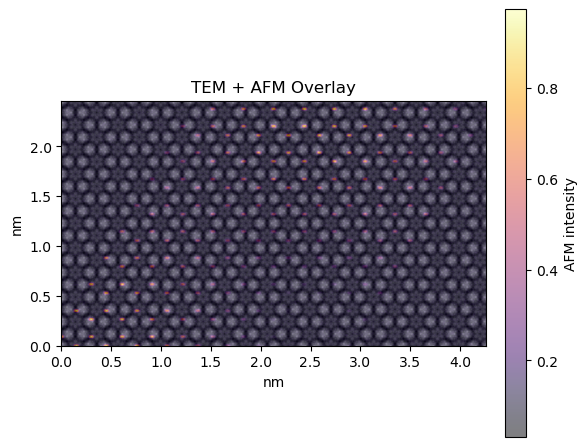

In [11]:
# ================================
# 7. Overlay TEM + AFM
# ================================
plt.figure(figsize=(6,6))
plt.imshow(tem_image, cmap='gray', extent=[0, w*tem_pixel_size_nm, 0, h*tem_pixel_size_nm])
plt.imshow(afm_resampled, cmap='inferno', alpha=0.5, extent=[0, w*tem_pixel_size_nm, 0, h*tem_pixel_size_nm])
plt.title('TEM + AFM Overlay')
plt.xlabel('nm')
plt.ylabel('nm')
plt.colorbar(label='AFM intensity', fraction=0.046, pad=0.04)
plt.show()